In [1]:
import random 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.figure
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.datasets import make_blobs 
from scipy.spatial import distance_matrix, distance
from scipy.cluster import hierarchy 
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler 
%matplotlib inline

In [2]:
def getData(fileText):
    #Get the data text sorted out
    column1 = []
    column2 = []
    for row in fileText.splitlines():
        if(row[7]!=" "):
            column1.append(row[7:15])
            column2.append(row[23:38])
    column1 = column1[10:455]
    column2 = column2[10:455]
    #Convert to numerical data     
    column1_num = pd.to_numeric(column1)
    column2_num = pd.to_numeric(column2)
    
    return [column1_num, column2_num]

In [26]:
class Cluster:
    def __init__(self, X, y, minX=6400, maxX=6800, minY=0, maxY=2):
        self.minX = minX
        self.maxX = maxX
        #Slices data to the specified range, default is 6400-6800 if no parameters specified
        beginning, end = np.searchsorted(X[0], [self.minX, self.maxX])
        for i in range(len(X)):
            X[i] = X[i][beginning:end]
            y[i] = y[i][beginning:end]
        self.X = X
        self.y = y
        self.maxY = maxY
        self.minY = minY
        
    def k_means_cluster(self):
        mpl.style.use('default')
        np.random.seed(0)
        X = self.y
        #Preprocess data
        X = StandardScaler().fit_transform(X)
        #Initialize clustering, fit the data
        k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)
        k_means.fit(X)
        #Get labels (clusters)
        labels = k_means.labels_
        cluster_centers = k_means.cluster_centers_
        fig = plt.figure(figsize=(6, 4))
        colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))
        ax = fig.add_subplot(1, 1, 1)
        score = k_means.score(X)
        print("SCORE IS "+str(score))
        #Produce scatter
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50)
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', s=200, alpha=0.5);
        plt.title('K-Means')
        plt.show()

        return labels
    
    def agglom_cluster(self):
        X = self.y
        mpl.style.use('seaborn-whitegrid')
        #Initialize clustering, fit the data
        agglom = AgglomerativeClustering(n_clusters = 3, linkage = 'average')
        agglom.fit(X)
        #Get labels (clusters)
        labels = agglom.labels_
        #Figure of size 6by 4 inches.
        plt.figure(figsize=(6,4))
        #Create a minimum and maximum range
        x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
        #Get the average distance
        X = (X - x_min) / (x_max - x_min)
        dist_matrix = distance.pdist(X, metric="jaccard")
        #Use distance to produce dendrogram
        Z = hierarchy.linkage(dist_matrix, 'average')
        dendro = hierarchy.dendrogram(Z)
        plt.title('Agglom')
        plt.show()
        #Produce scatter
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50)
        plt.title('Agglom')
        plt.show()
        return labels
    
    def spectral_cluster(self):
        X = self.y
        mpl.style.use('seaborn-whitegrid')
        #Preprocess data
        X = StandardScaler().fit_transform(X)
        #Initialize clustering, fit the data
        clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=0)
        clustering.fit(X)
        #Get labels (clusters)
        labels =  clustering.labels_
        #Figure 6 by 4 inches
        fig = plt.figure(figsize=(6, 4))
        colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))
        ax = fig.add_subplot(1, 1, 1)
        #Produce scatter
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50)
        plt.title('Spectral')
        plt.show()
        
        return labels
    
    def graph(self, cluster_array):
        mpl.style.use('seaborn-whitegrid')
        #cluster_array = np.array([3, 3, 3, 1, 1, 3, 0, 3, 1, 0, 2, 0, 3, 3])
        arrays = []
        filearrs = []
        for i in range(np.max(cluster_array)+1):
            arrays.append([])
            filearrs.append([])
        index = 0
        path = "/Users/johnrussell/Desktop/Mn-XAFS-Data/*.nor"
        for file in glob.glob(path):
            if(file=="/Users/johnrussell/Desktop/Mn-XAFS-Data/Ti16Mn1Ox_600_Mn_edge.nor"):
                index = index+1
                continue
            fileCSV = pd.read_csv(file, skiprows=37)
            fileText = fileCSV.to_string()
            column1 = []
            column2 = []
            for row in fileText.splitlines():
                if(row[7]!=" "):
                    column1.append(row[7:15])
                    column2.append(row[23:38])
            #Convert to numerical data     
            column1_num = pd.to_numeric(column1)
            column2_num = pd.to_numeric(column2)
            columns_df = pd.DataFrame(data=np.array([column1_num, column2_num])).transpose()
            columns_df.columns = ['X','Y']
            cluster_arr_index = cluster_array[index]
            #print(cluster_arr_index)
            arrays[cluster_arr_index].append(columns_df)
            #filearrs[cluster_arr_index].append(file[file.index('XAFS')+10:file.index('.nor')])
            index = index + 1

        figs = []
        fig = plt.figure()
        subplots = []
        #print(len(arrays[3]))
        for i in range(len(arrays)):
            figs.append(plt.figure())
            #subplots.append(fig.add_subplot(2, 2, i+1))
        for i in range(len(arrays)):
            ax = figs[i].add_subplot()
            #print(filearrs[i])
            for figure in arrays[i]:
                mpl.style.use('seaborn-whitegrid')
                #print(figure.index)
                figure.plot(x='X', y='Y', kind='line', figsize=(20,10), xlim=(self.minX, self.maxX), ylim=(self.minY,self.maxY), ax=ax)
            ax.set_xlabel('Energy   (eV)')
            ax.set_ylabel('normalized xµ(E)')
            #ax.set_title('X and Y')
            ax.legend(filearrs[i])

In [9]:
class Graph:
    def __init__(self, minX=6400, maxX=6800, minY=0, maxY=2):
        self.minX = minX
        self.maxX = maxX
        self.maxY = maxY
        self.minY = minY
    def each_graph(self):
        mpl.style.use('seaborn-whitegrid')
        path = "/Users/johnrussell/Desktop/Mn-XAFS-Data/*.nor"
        files = []
        for file in glob.glob(path):
            #print(file[file.index('XAFS'):]+"\n")
            fileCSV = pd.read_csv(file, skiprows=37)
            fileText = fileCSV.to_string()
            files.append(file[file.index('XAFS')+10:file.index('.nor')])
            column1 = []
            column2 = []
            for row in fileText.splitlines():
                if(row[7]!=" "):
                    column1.append(row[7:15])
                    column2.append(row[23:38])
            #Convert to numerical data     
            column1_num = pd.to_numeric(column1)
            column2_num = pd.to_numeric(column2)
            columns_df = pd.DataFrame(data=np.array([column1_num, column2_num])).transpose()
            columns_df.columns = ['X','Y']
            mpl.style.use('seaborn-whitegrid')
            columns_df.plot(x='X', y='Y', kind='line', figsize=(20,10), xlim=(self.minX, self.maxX),ylim=(self.minY,self.maxY))
            plt.legend(files)
            del files[0]
    def all_graphs(self):
        mpl.style.use('seaborn-whitegrid')
        path = "/Users/johnrussell/Desktop/Mn-XAFS-Data/*.nor"
        fig = plt.figure()
        files = []
        for file in glob.glob(path):
            ax = fig.add_subplot()
            fileCSV = pd.read_csv(file, skiprows=37)
            fileText = fileCSV.to_string()
            files.append(file[file.index('XAFS')+10:file.index('.nor')])
            column1 = []
            column2 = []
            for row in fileText.splitlines():
                if(row[7]!=" "):
                    column1.append(row[7:15])
                    column2.append(row[23:38])
            #Convert to numerical data     
            column1_num = pd.to_numeric(column1)
            column2_num = pd.to_numeric(column2)

            columns_df = pd.DataFrame(data=np.array([column1_num, column2_num])).transpose()
            columns_df.columns = ['Energy   (eV)','normalized xµ(E)']
            mpl.style.use('seaborn-whitegrid')
            ax.set_xlabel('Energy   (eV)')
            ax.set_ylabel('normalized xµ(E)')
            columns_df.plot(x='Energy   (eV)', y='normalized xµ(E)', kind='line', xlim=(self.minX, self.maxX),ylim=(self.minY,self.maxY), figsize=(20,10), ax=ax)
            #plt.legend(files)
            plt.legend([])
    

In [10]:
path = "/Users/johnrussell/Desktop/Mn-XAFS-Data/*.nor"
#datapoints = []
xdata = []
ydata = []
num = 0
#Get data from all the files
for file in glob.glob(path):
    #print(num, file[file.index('XAFS'):]+"\n")
    num = num + 1
    fileCSV = pd.read_csv(file, skiprows=37)
    fileString = fileCSV.to_string()
    xdata.append(getData(fileString)[0])
    ydata.append(getData(fileString)[1])

In [27]:
#We can define constant variables for the ranges of pre, edge, and post
#Note: pre-edge results are unsatisfactory, graphs too similar at that point
#pre_beg = 6520
#pre_end = 6540
#edge_beg =
#edge_end =

c = Cluster(xdata, ydata, 6500, 6700, 0, 2)

SCORE IS -5095.447728461496


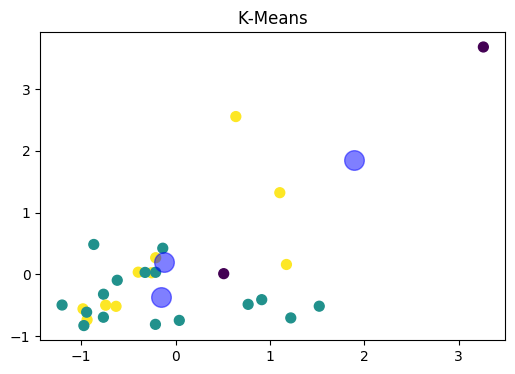

K-Means
[2 2 2 1 2 0 1 1 1 2 1 1 0 1 2 1 1 1 1 2 1 2 1 1 1 2 1 2]


In [28]:
#Run k_means
k_means_arr = c.k_means_cluster()
#c.graph(k_means_arr)
print('K-Means')
print(k_means_arr)

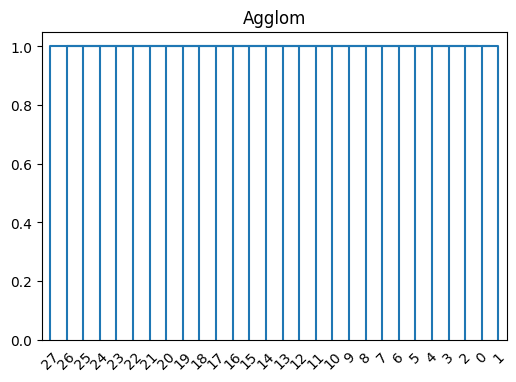

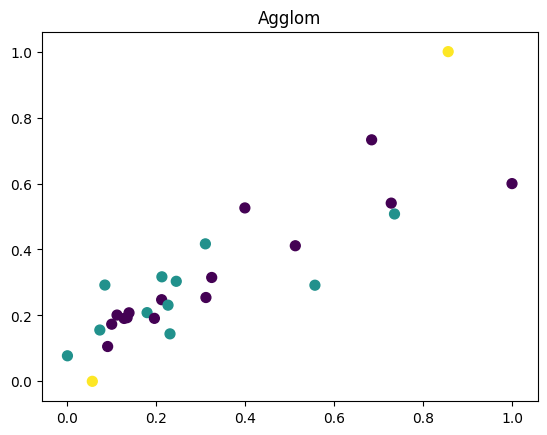

Agglom
[1 1 1 0 1 2 0 1 0 1 0 0 2 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1]


<Figure size 640x480 with 0 Axes>

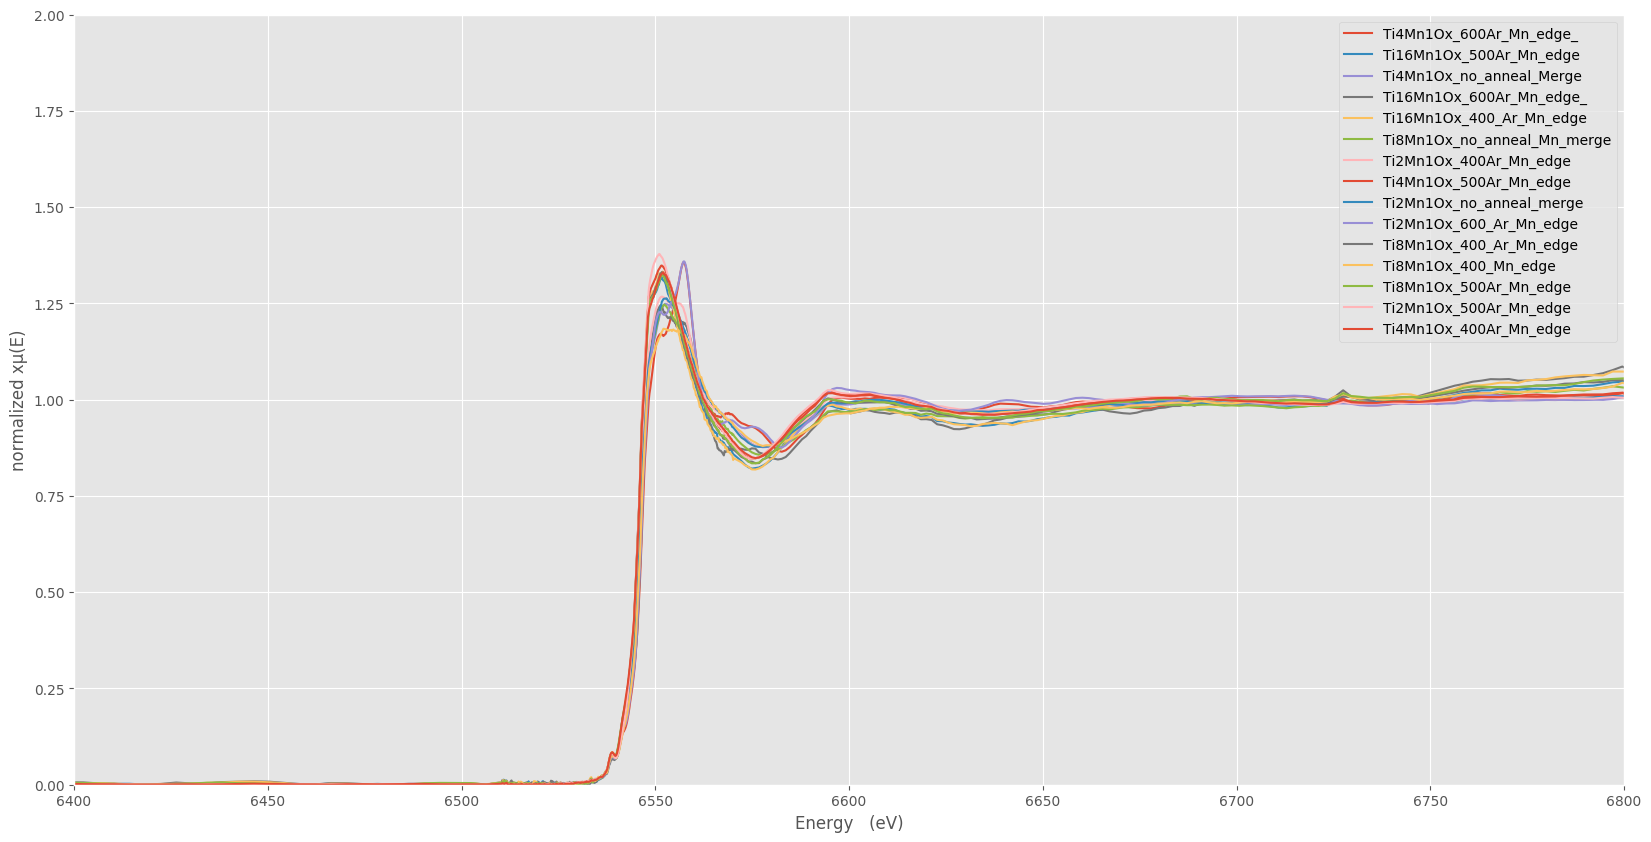

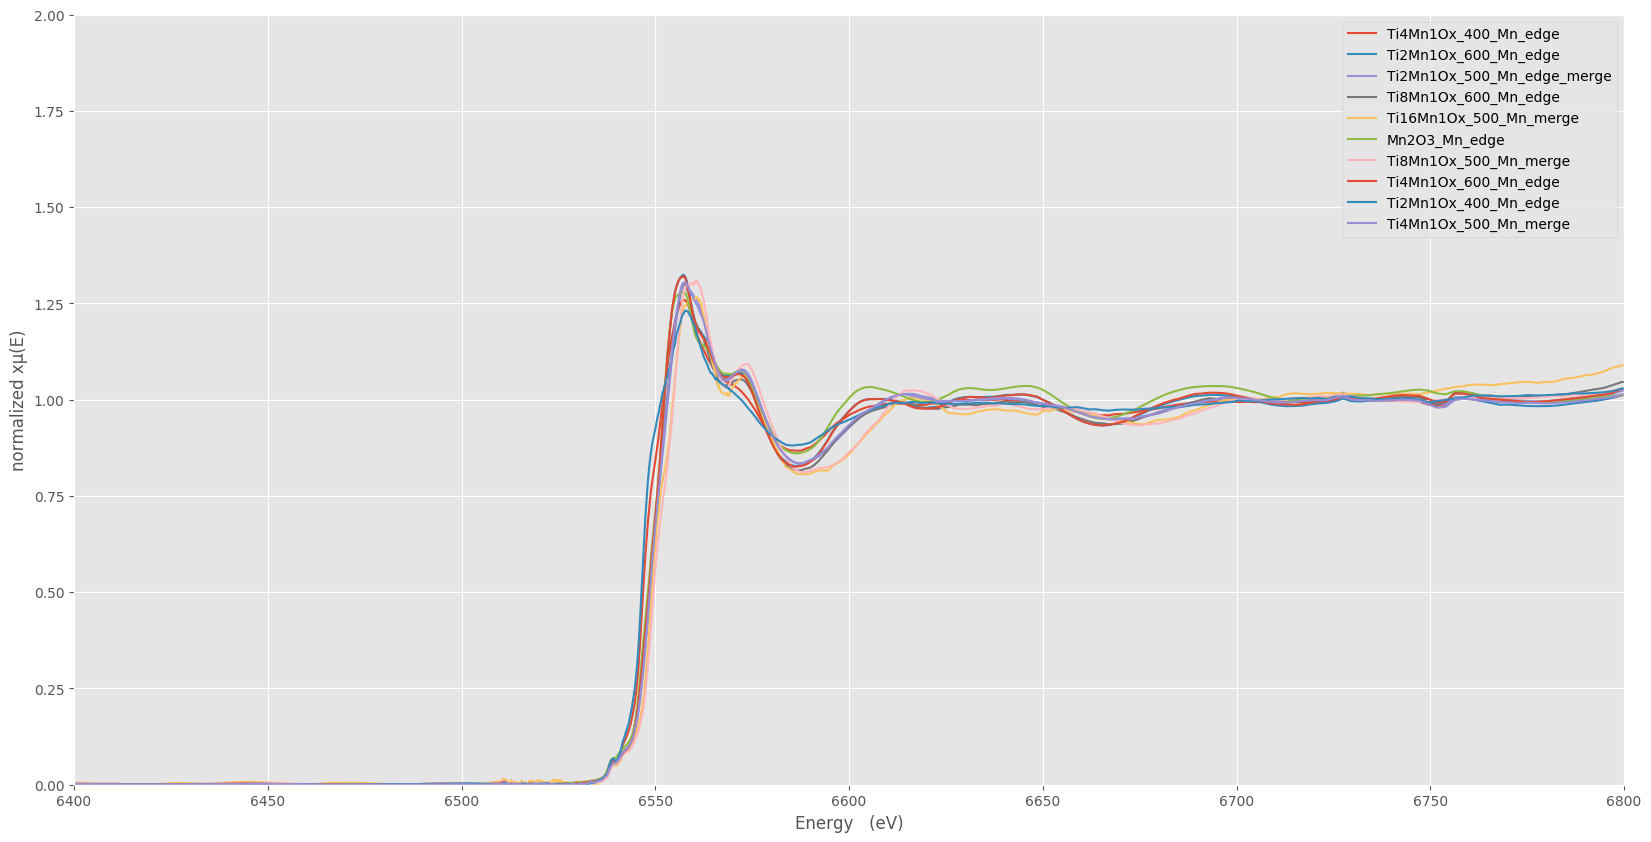

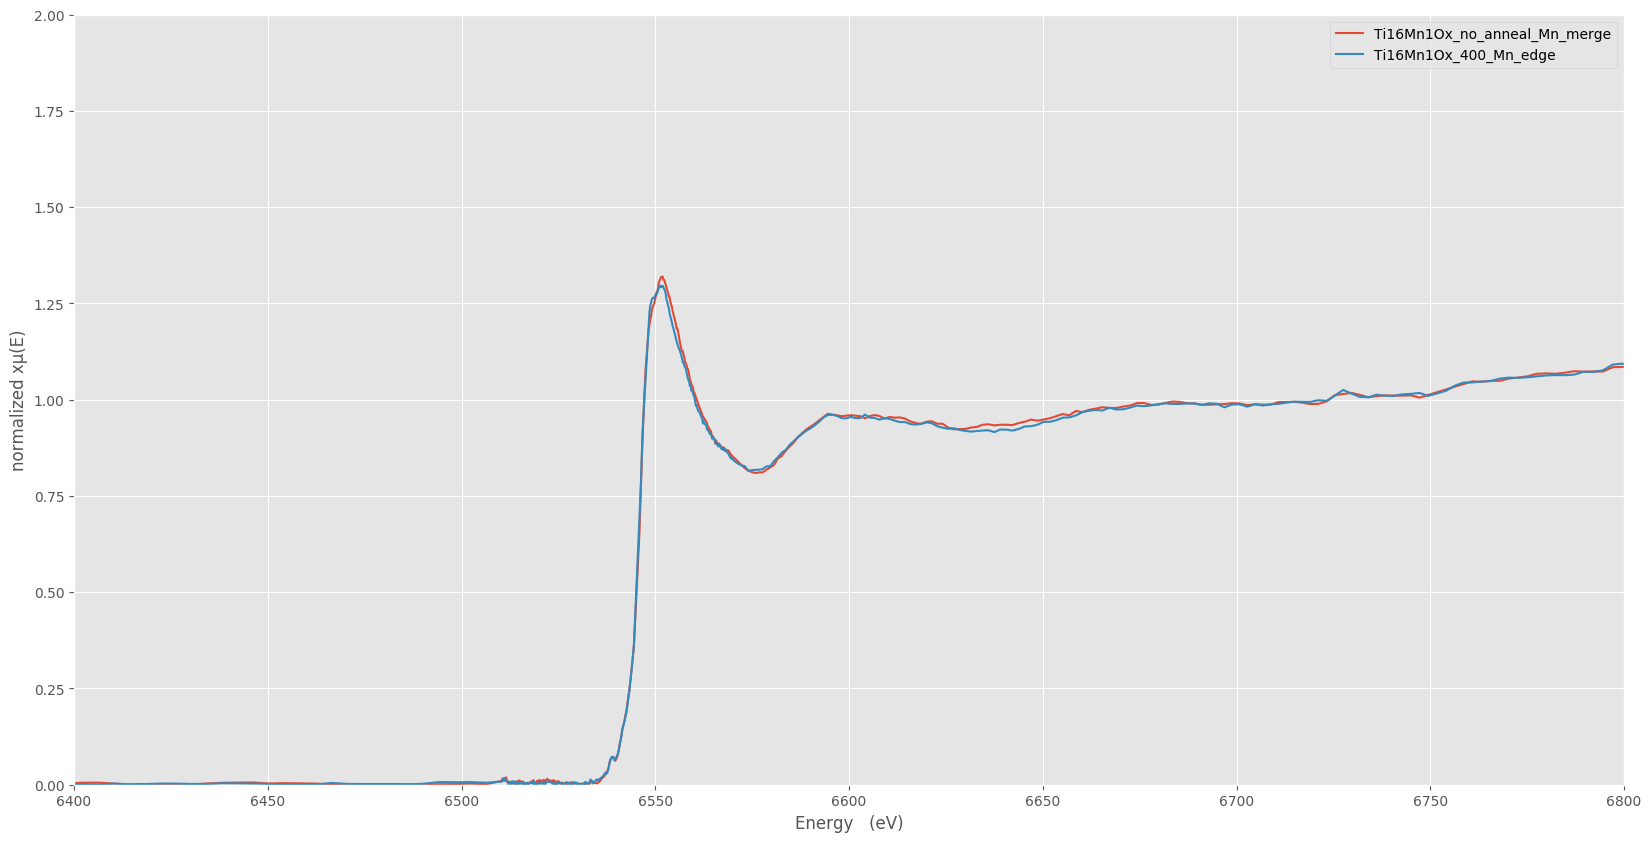

In [27]:
#Run agglom
agglom_arr = c.agglom_cluster()
print('Agglom')
print(agglom_arr)
c.graph(agglom_arr)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


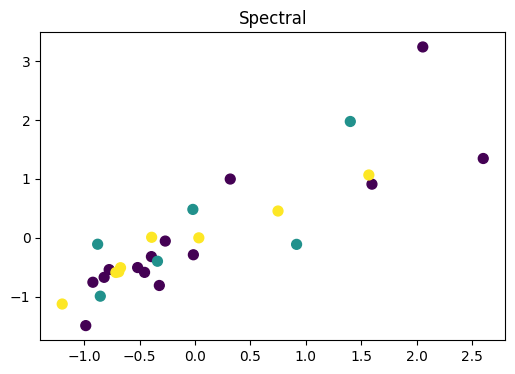

Spectral
[0 0 1 0 0 0 2 1 0 0 0 1 0 2 2 0 2 0 1 1 0 0 0 2 2 2 2 1]


<Figure size 640x480 with 0 Axes>

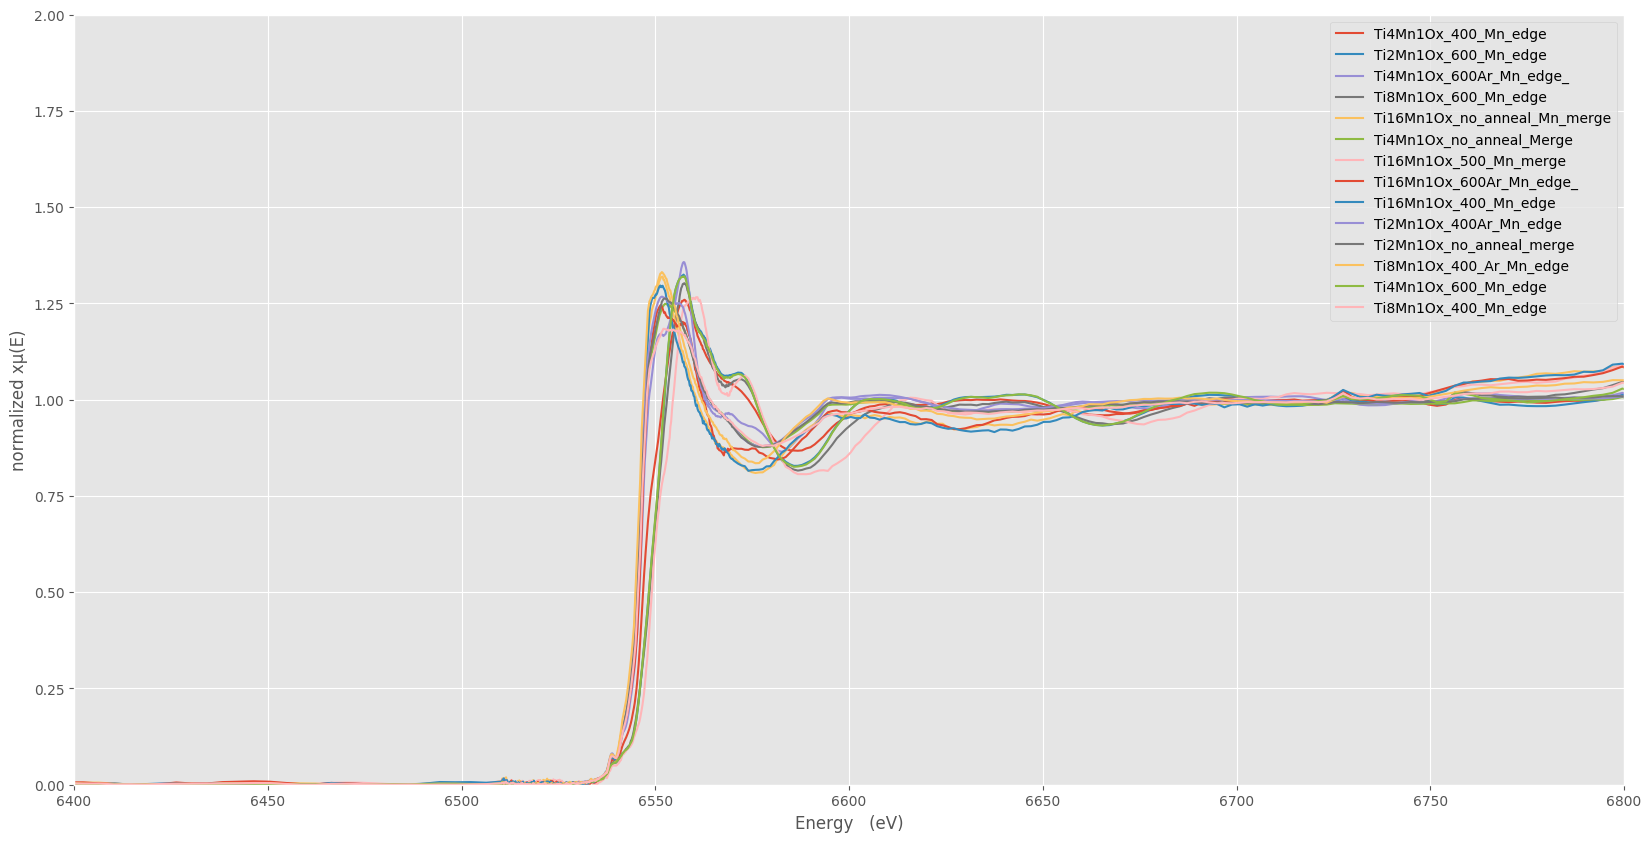

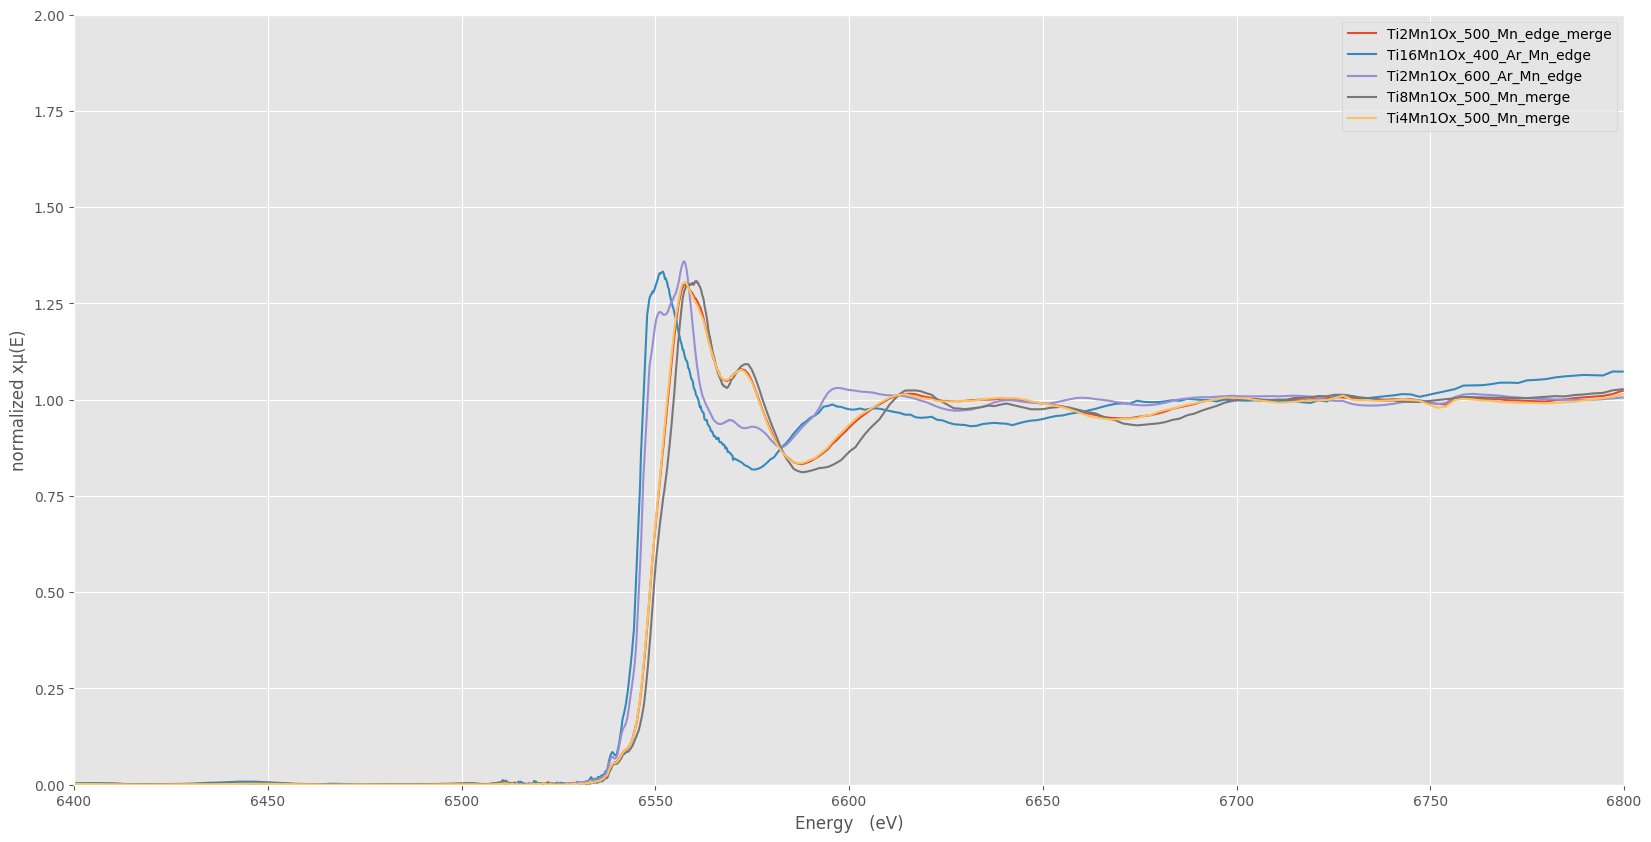

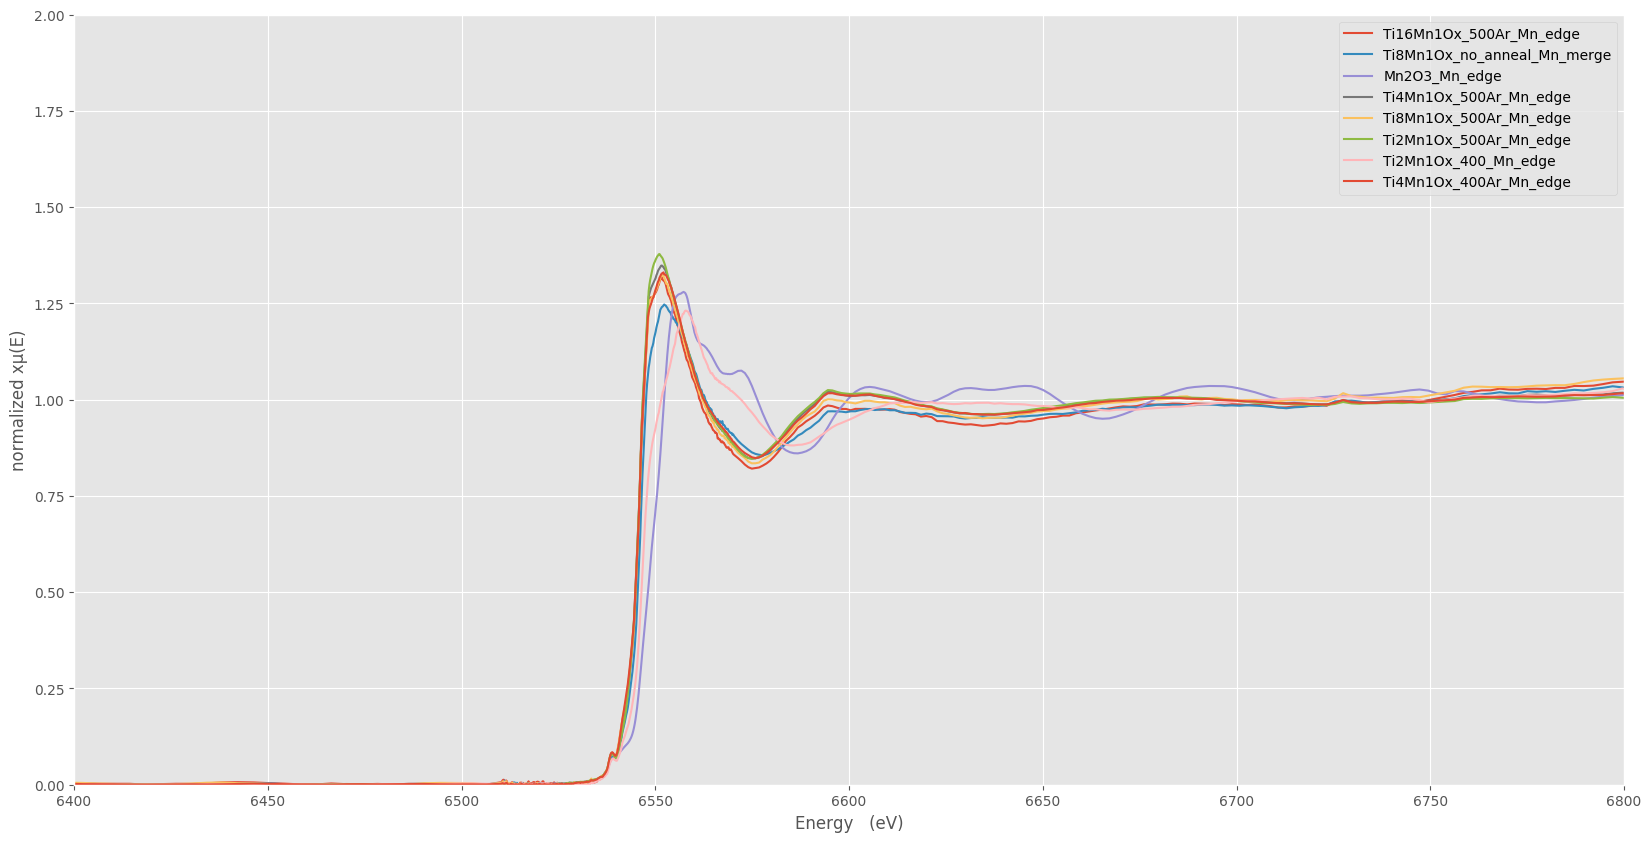

In [28]:
#Run spectral
spectral_arr = c.spectral_cluster()
print('Spectral')
print(spectral_arr)
c.graph(spectral_arr)

In [ ]:
#Testruns of: 
testruns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Ad

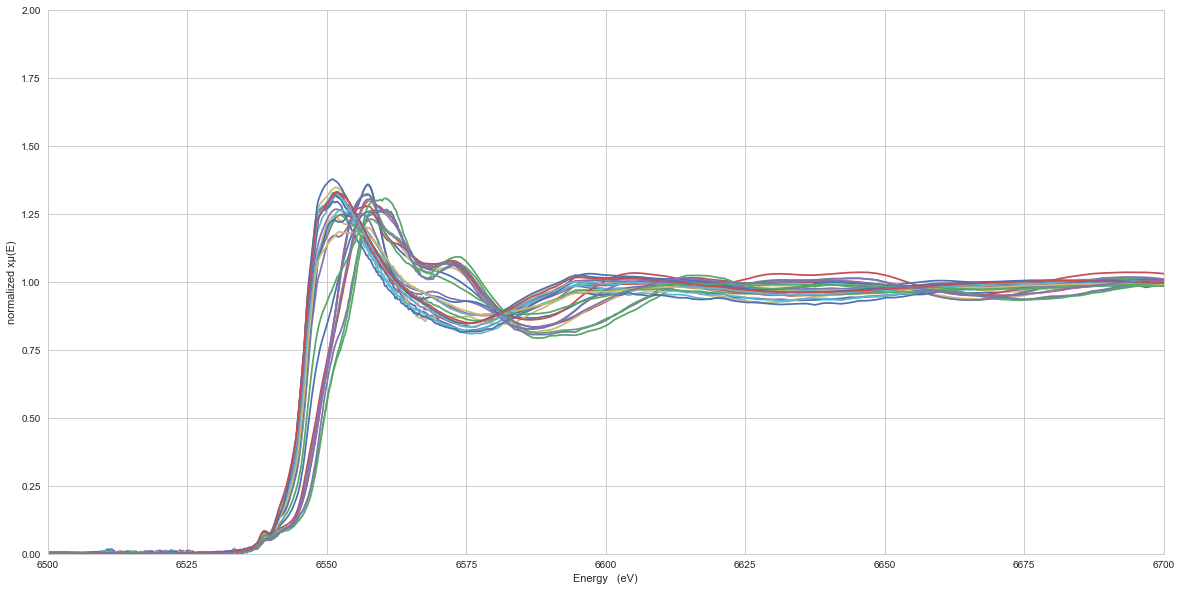

In [82]:
g = Graph(6500, 6700, 0, 2)
g.all_graphs()